In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import time
import wandb
import torch
import random
import pickle
import imageio
import librosa
import torchvision

import numpy as np
import pandas as pd
import torchmetrics as tm 
import plotly.express as px
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from torch import nn
from pathlib import Path, PurePath
from IPython.display import Audio
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, AdamW, RMSprop # optmizers
from warmup_scheduler import GradualWarmupScheduler
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau # Learning rate schedulers

import albumentations as A
# from albumentations.pytorch import ToTensorV2

import timm

In [3]:
print('timm version', timm.__version__)
print('torch version', torch.__version__)

timm version 0.9.16
torch version 2.3.0


In [4]:
# print(os.getenv('wandb_api_key'))

In [5]:
wandb.login(key=os.getenv('wandb_api_key'))

wandb: Currently logged in as: rosu-lucian. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Asus\.netrc


True

In [6]:
# detect and define device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


### Config

In [7]:
train_dir = Path('E:\data\BirdCLEF')

In [8]:
class CFG:
    project = 'Bird-local-3'
    comment = 'clean-size192-topdb60'
    
    MIXUP = True
    USE_SCHD = False
    USE_UL = False
    # USE_MISSING_LABELS = False
    USE_SECONDARY = True
    USE_MISSING_LABELS = USE_SECONDARY
    USE_UPSAMPLE = False

    UL_THRESH = 0.05
    up_thr = 50
    
    # Competition Root Folder
    ROOT_FOLDER = train_dir
    birds_csv = train_dir / 'bird_preds.csv'
    AUDIO_FOLDER = train_dir / 'train_audio'
    DATA_DIR = train_dir / 'spectros'
    TRAIN_CSV = train_dir / 'train_metadata.csv'
    UNLABELED_CSV = train_dir / 'predictions.csv'
    RESULTS_DIR = train_dir / 'results'
    CKPT_DIR = RESULTS_DIR / 'ckpt'

    num_workers = 8
    # Maximum decibel to clip audio to
    # TOP_DB = 100
    TOP_DB = 60
    # Minimum rating
    MIN_RATING = 3.0
    # Sample rate as provided in competition description
    # SR = 32000
    SR = 32000

    image_size_x = 128
    image_size_y = 192
    
    ### split train and validation sets
    split_fraction = 0.95
    
    ### model
    model_name = 'eca_nfnet_l0' # 'resnet34', 'resnet200d', 'efficientnet_b1_pruned', 'efficientnetv2_m', efficientnet_b7 ...  
    
    ### training
    BATCH_SIZE = 128

    ### Optimizer
    N_EPOCHS = 240
    WARM_EPOCHS = 3
    COS_EPOCHS = N_EPOCHS - WARM_EPOCHS
    
    # LEARNING_RATE = 5*1e-5 # best
    LEARNING_RATE = 5e-5
    
    weight_decay = 1e-6 # for adamw

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    random_seed = 42

mel_spec_params = {
    "sample_rate": CFG.SR,
    "n_mels": 128,
    "f_min": 150,
    "f_max": CFG.SR / 2,
    "n_fft": 2048,
    "hop_length": 512,
    "normalized": True,
    "center" : True,
    "pad_mode" : "constant",
    "norm" : "slaney",
    "mel_scale" : "slaney"
}

CFG.mel_spec_params = mel_spec_params

sec_labels = ['lotshr1', 'orhthr1', 'magrob', 'indwhe1', 'bltmun1', 'asfblu1']

sample_submission = pd.read_csv(train_dir / 'sample_submission.csv')

# Set labels
CFG.LABELS = sample_submission.columns[1:].tolist()
if CFG.USE_MISSING_LABELS:
    CFG.LABELS += sec_labels
    
CFG.N_LABELS = len(CFG.LABELS)
print(f'# labels: {CFG.N_LABELS}')

bird2id = {b: i for i, b in enumerate(CFG.LABELS)}

display(sample_submission.head())

# labels: 188


,row_id,asbfly,ashdro1,ashpri1,ashwoo2,asikoe2,asiope1,aspfly1,aspswi1,barfly1,...,whbwoo2,whcbar1,whiter2,whrmun,whtkin2,woosan,wynlau1,yebbab1,yebbul3,zitcis1
0,soundscape_1446779_5,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,...,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495
1,soundscape_1446779_10,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,...,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495
2,soundscape_1446779_15,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,...,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495,0.005495


In [9]:
CFG.N_LABELS

188

In [10]:
# for reproducibility
def seed_torch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed = CFG.random_seed)

In [11]:
meta_df = pd.read_csv(CFG.TRAIN_CSV)
meta_df.head(2)

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename,file,duration
0,asbfly,[],['call'],39.2297,118.1987,Muscicapa dauurica,Asian Brown Flycatcher,Matt Slaymaker,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/134896,asbfly/XC134896.ogg,XC134896.ogg,27
1,asbfly,[],['song'],51.4030,104.6401,Muscicapa dauurica,Asian Brown Flycatcher,Magnus Hellström,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/164848,asbfly/XC164848.ogg,XC164848.ogg,15


In [12]:
columns = ['primary_label', 'secondary_labels', 'filename', 'file', 'duration']

In [13]:
meta_df['file'] = meta_df.apply(lambda row: row['filename'].split('/')[-1], axis=1)
meta_df['filename'] = fr'{str(CFG.AUDIO_FOLDER)}/' + meta_df['filename']

In [14]:
meta_df[columns].head(2)

,primary_label,secondary_labels,filename,file,duration
0,asbfly,[],E:\data\BirdCLEF\train_audio/asbfly/XC134896.ogg,XC134896.ogg,27
1,asbfly,[],E:\data\BirdCLEF\train_audio/asbfly/XC164848.ogg,XC164848.ogg,15


In [15]:
meta_df.iloc[0].filename

'E:\\data\\BirdCLEF\\train_audio/asbfly/XC134896.ogg'

### Load data

In [16]:
from dataset import bird_dataset2

In [17]:
dset = bird_dataset2(meta_df, CFG)

print(dset.__len__())

spect, label, = dset.__getitem__(0)
print(spect.shape, label.shape)
print(spect.dtype, label.dtype)

24459
torch.Size([3, 128, 313]) torch.Size([188])
torch.float32 torch.float32


In [18]:
label.sum()

tensor(1.)

In [19]:
# interv.intersect.sum()

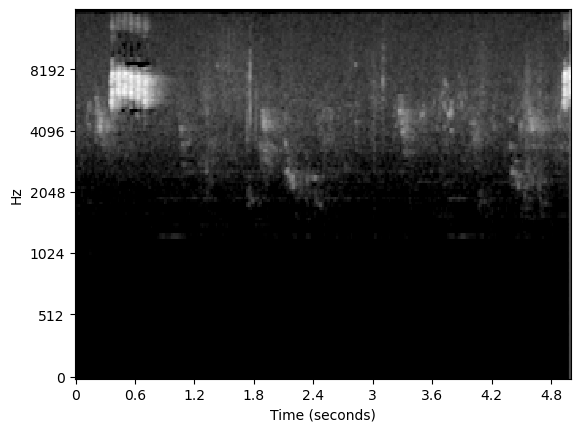

In [20]:
librosa.display.specshow(spect[0].numpy(), y_axis="mel", x_axis='s', sr=CFG.SR, cmap='gray')
plt.show()

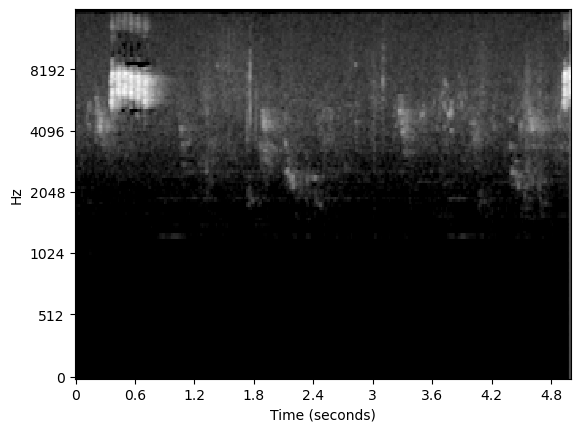

In [21]:
librosa.display.specshow(spect[1].numpy(), y_axis="mel", x_axis='s', sr=CFG.SR, cmap='gray')
plt.show()

### Data Module

In [22]:
from dataset import bird_dataset2

In [23]:
class wav_datamodule(pl.LightningDataModule):
    def __init__(self, train_df, val_df, cfg=CFG, train_tfs=None, val_tfs=None):
        super().__init__()
        
        self.train_df = train_df
        self.val_df = val_df
        
        self.train_bs = cfg.BATCH_SIZE
        self.val_bs = cfg.BATCH_SIZE

        self.train_tfs = train_tfs
        self.val_tfs = val_tfs

        self.cfg = cfg
        
        self.num_workers = cfg.num_workers
        
    def train_dataloader(self):
        train_ds = bird_dataset2(self.train_df, self.cfg, tfs=self.train_tfs, mode='train')
        
        train_loader = torch.utils.data.DataLoader(
            train_ds,
            batch_size=self.train_bs,
            pin_memory=False,
            drop_last=False,
            shuffle=True,
            persistent_workers=True,
            num_workers=self.num_workers,
        )
        
        return train_loader
        
    def val_dataloader(self):
        val_ds = bird_dataset2(self.val_df, self.cfg, tfs=self.val_tfs, mode='val')
        
        val_loader = torch.utils.data.DataLoader(
            val_ds,
            batch_size=self.val_bs,
            pin_memory=False,
            drop_last=False,
            shuffle=False,
            persistent_workers=True,
            num_workers=2,
        )
        
        return val_loader

In [24]:
image_size_x = CFG.image_size_x
image_size_y = CFG.image_size_y

train_tfs = A.Compose([
    # A.HorizontalFlip(p=0.5),
    A.Resize(image_size_x, image_size_y),
    # A.GaussNoise(var_limit=0.2, mean=1, p=0.5),
    A.XYMasking(num_masks_x=(1,4), num_masks_y=(1,3), mask_x_length=(8,16), mask_y_length=(8,18), p=0.7),
    # A.CoarseDropout(max_height=int(image_size * 0.375), max_width=int(image_size * 0.375), max_holes=1, p=0.7),
    A.Normalize()
])

val_tfs = A.Compose([
    A.Resize(image_size_x, image_size_y),
    A.Normalize()
])

In [25]:
t_df = meta_df[:-100]
# t_df = pd.concat([meta_df[:-100], ul_df[:-100]], ignore_index=True)
v_df = meta_df[-100:]

CFG2 = CFG()
CFG2.BATCH_SIZE = 16
CFG2.num_workers = 2

dm = wav_datamodule(t_df, v_df, cfg=CFG2)
# dm = wav_datamodule(t_df, v_df, cfg=CFG, train_tfs=train_tfs, val_tfs=val_tfs)

x, y = next(iter(dm.train_dataloader()))
x.shape, y.shape, x.dtype, y.dtype

(torch.Size([16, 3, 128, 313]),
 torch.Size([16, 188]),
 torch.float32,
 torch.float32)

In [26]:
# librosa.display.specshow(x[0].numpy()[0], y_axis="mel", x_axis='s', sr=CFG.SR)
# plt.show()

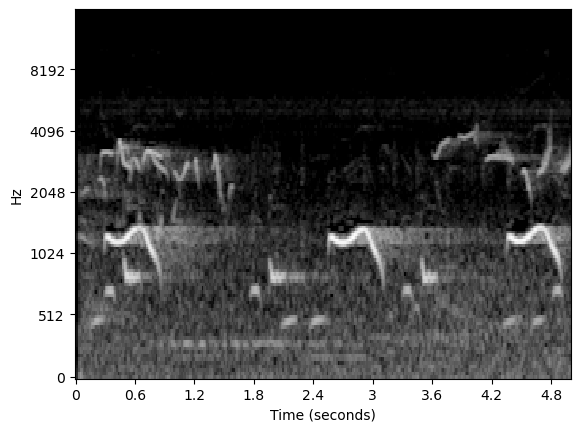

In [27]:
librosa.display.specshow(x[2].numpy()[0], y_axis="mel", x_axis='s', sr=CFG.SR, cmap='gray')
plt.show()

In [28]:
dm = wav_datamodule(t_df, v_df, cfg=CFG2, train_tfs=train_tfs, val_tfs=val_tfs)

x, y = next(iter(dm.train_dataloader()))
x.shape, y.shape, x.dtype, y.dtype

(torch.Size([16, 3, 128, 192]),
 torch.Size([16, 188]),
 torch.float32,
 torch.float32)

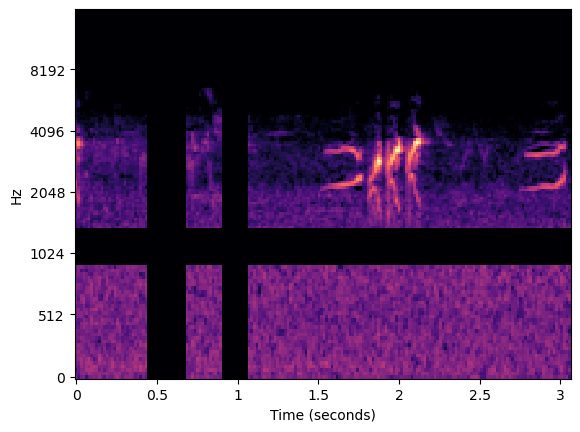

In [29]:
librosa.display.specshow(x[0].numpy()[0], y_axis="mel", x_axis='s', sr=CFG.SR)
plt.show()

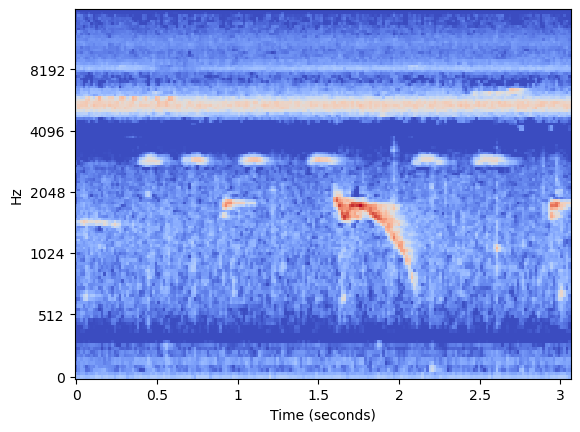

In [30]:
librosa.display.specshow(x[1].numpy()[0], y_axis="mel", x_axis='s', sr=CFG.SR)
plt.show()

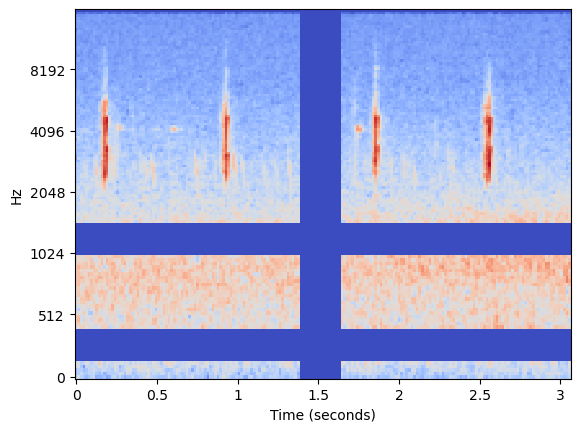

In [31]:
librosa.display.specshow(x[2].numpy()[0], y_axis="mel", x_axis='s', sr=CFG.SR)
plt.show()

In [32]:
# img = x[0]
# img.shape, img.unsqueeze(dim=0).numpy().shape, img.expand(3, -1, -1).shape

In [33]:
# img.expand(3, -1, -1).permute(1, 2, 0).shape, img.expand(3, -1, -1).permute(1, 2, 0).numpy().transpose(2,0,1).shape

In [34]:
# train_tfs(image=img.numpy())

In [35]:
del dm

### Loss function

In [36]:
class FocalLossBCE(torch.nn.Module):
    def __init__(
            self,
            alpha: float = 0.25,
            gamma: float = 2,
            reduction: str = "mean",
            bce_weight: float = 1.0,
            focal_weight: float = 1.0,
    ):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.bce = torch.nn.BCEWithLogitsLoss(reduction=reduction)
        self.bce_weight = bce_weight
        self.focal_weight = focal_weight

    def forward(self, logits, targets):
        focall_loss = torchvision.ops.focal_loss.sigmoid_focal_loss(
            inputs=logits,
            targets=targets,
            alpha=self.alpha,
            gamma=self.gamma,
            reduction=self.reduction,
        )
        bce_loss = self.bce(logits, targets)
        return self.bce_weight * bce_loss + self.focal_weight * focall_loss

In [37]:
class GeM(torch.nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM, self).__init__()
        self.p = torch.nn.Parameter(torch.ones(1) * p)
        self.eps = eps

    def forward(self, x):
        bs, ch, h, w = x.shape
        x = torch.nn.functional.avg_pool2d(x.clamp(min=self.eps).pow(self.p), (x.size(-2), x.size(-1))).pow(
            1.0 / self.p)
        x = x.view(bs, ch)
        return x

### Optimizer

In [38]:
# Fix Warmup Bug
class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(optimizer, multiplier, total_epoch, after_scheduler)
        
    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                    
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
            
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

### Model

In [39]:
print('Number of models available: ', len(timm.list_models(pretrained=True)))
print('Number of models available: ', len(timm.list_models()))
print('\ models: ', timm.list_models('eca_nfnet_*'))

Number of models available:  1329
Number of models available:  1032
\ models:  ['eca_nfnet_l0', 'eca_nfnet_l1', 'eca_nfnet_l2', 'eca_nfnet_l3']


In [40]:
backbone = 'eca_nfnet_l1'
# backbone = 'efficientnet_b4'
out_indices = (3, 4)

model = timm.create_model(
    backbone,
    features_only=True,
    pretrained=False,
    in_chans=3,
    num_classes=5,
    # out_indices=out_indices,
    )

model.feature_info.channels(), np.sum(model.feature_info.channels())

([64, 256, 512, 1536, 3072], 5440)

In [41]:
def mixup(data, targets, alpha, device):
    indices = torch.randperm(data.size(0))
    data2 = data[indices]
    targets2 = targets[indices]

    lam = torch.FloatTensor([np.random.beta(alpha, alpha)]).to(device)
    data = data * lam + data2 * (1 - lam)
    
    targets = targets * lam + targets2 * (1 - lam)
    return data, targets

    # data += data2
    # targets += targets2
    # return data, targets.clip(max=1)

In [42]:
class GeMModel(pl.LightningModule):
    def __init__(self, cfg = CFG, pretrained = True):
        super().__init__()

        self.cfg = cfg
        
        out_indices = (3, 4)

        self.criterion = FocalLossBCE()

        self.train_acc = tm.classification.MulticlassAccuracy(num_classes=self.cfg.N_LABELS)
        self.val_acc = tm.classification.MulticlassAccuracy(num_classes=self.cfg.N_LABELS)

        # self.train_acc = tm.classification.MultilabelAccuracy(num_labels=self.cfg.N_LABELS)
        self.val_macc = tm.classification.MultilabelAccuracy(num_labels=self.cfg.N_LABELS)

        self.train_auroc = tm.classification.MulticlassAUROC(num_classes=self.cfg.N_LABELS)
        self.val_auroc = tm.classification.MulticlassAUROC(num_classes=self.cfg.N_LABELS)

        # self.model_name = self.cfg.model_name
        print(self.cfg.model_name)
        
        self.backbone = timm.create_model(
            self.cfg.model_name, 
            features_only=True,
            pretrained=pretrained,
            in_chans=3,
            num_classes=self.cfg.N_LABELS,
            out_indices=out_indices,
        )

        feature_dims = self.backbone.feature_info.channels()

        self.global_pools = torch.nn.ModuleList([GeM() for _ in out_indices])
        self.mid_features = np.sum(feature_dims)
        
        self.neck = torch.nn.BatchNorm1d(self.mid_features)
        self.head = torch.nn.Linear(self.mid_features, self.cfg.N_LABELS)

    def forward(self, x):
        ms = self.backbone(x)
        
        h = torch.cat([global_pool(m) for m, global_pool in zip(ms, self.global_pools)], dim=1)
        x = self.neck(h)
        x = self.head(x)
        
        return x
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(model.parameters(), lr=self.cfg.LEARNING_RATE, weight_decay=CFG.weight_decay)
        
        if self.cfg.USE_SCHD:
            scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, self.cfg.COS_EPOCHS)
            scheduler_warmup = GradualWarmupSchedulerV2(optimizer, multiplier=10, total_epoch=self.cfg.WARM_EPOCHS, after_scheduler=scheduler_cosine)

            return [optimizer], [scheduler_warmup]
        else:
            # LRscheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.2)
            
            # return [optimizer], [LRscheduler]
            return optimizer

    def step(self, batch, batch_idx, mode='train'):
        x, y = batch

        if self.cfg.MIXUP and mode == 'train':
            x, y = mixup(x, y, 0.5, self.cfg.device)
        
        preds = self(x)
        
        loss = self.criterion(preds, y)
        
        if mode == 'train':
            self.train_acc(preds, y.argmax(1))
            # self.train_auroc(preds, y.argmax(1))
        else:
            self.val_acc(preds, y.argmax(1))
            self.val_macc(preds, y)
            # self.val_auroc(preds, y.argmax(1))
        
        self.log(f'{mode}/loss', loss, on_step=True, on_epoch=True)
        # self.log(f'{mode}/kl_loss', kl_loss, on_step=True, on_epoch=True)

        return loss
    
    def training_step(self, batch, batch_idx):
        loss = self.step(batch, batch_idx, mode='train')
        self.log(f'train/acc', self.train_acc, on_step=True, on_epoch=True)
        # self.log(f'train/auroc', self.train_auroc, on_step=True, on_epoch=True)
        
        return loss
        
    def validation_step(self, batch, batch_idx):
        loss = self.step(batch, batch_idx, mode='val')
        self.log(f'val/acc', self.val_acc, on_step=True, on_epoch=True)
        self.log(f'val/macc', self.val_macc, on_step=True, on_epoch=True)
        # self.log(f'val/auroc', self.val_auroc, on_step=True, on_epoch=True)
    
        return loss
    
    def on_train_epoch_end(self):
        self.train_acc.reset()

    def on_validation_epoch_end(self):
        self.val_acc.reset()
        self.val_macc.reset()

In [43]:
model = GeMModel(CFG)

eca_nfnet_l0


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/eca_nfnet_l0.ra2_in1k)
INFO:timm.models._hub:[timm/eca_nfnet_l0.ra2_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Missing keys (head.fc.weight, head.fc.bias) discovered while loading pretrained weights. This is expected if model is being adapted.


In [44]:
foo = model(x)

In [45]:
foo.shape

torch.Size([16, 188])

### Split

In [46]:
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit

In [47]:
def upsample_data(df, thr=20):
    # get the class distribution
    class_dist = df['primary_label'].value_counts()

    # identify the classes that have less than the threshold number of samples
    down_classes = class_dist[class_dist < thr].index.tolist()

    # create an empty list to store the upsampled dataframes
    up_dfs = []

    # loop through the undersampled classes and upsample them
    for c in down_classes:
        # get the dataframe for the current class
        class_df = df.query("primary_label==@c")
        # find number of samples to add
        num_up = thr - class_df.shape[0]
        # upsample the dataframe
        class_df = class_df.sample(n=num_up, replace=True, random_state=CFG.random_seed)
        # append the upsampled dataframe to the list
        up_dfs.append(class_df)

    # concatenate the upsampled dataframes and the original dataframe
    up_df = pd.concat([df] + up_dfs, axis=0, ignore_index=True)
    
    return up_df

In [48]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=1-CFG.split_fraction, random_state=CFG.random_seed)
train_idx, val_idx = next(sss.split(meta_df.filename, meta_df.primary_label))

t_df = meta_df.iloc[train_idx]
v_df = meta_df.iloc[val_idx]

print(t_df.shape)

if not CFG.USE_SECONDARY:
    t_df = t_df[t_df['secondary_labels'] == '[]']

if CFG.USE_UPSAMPLE:
    t_df = upsample_data(t_df, thr=CFG.up_thr)

if CFG.USE_UL:
    t_df = pd.concat([t_df, ul_df], ignore_index=True)

t_df.shape, v_df.shape

(23236, 14)


((23236, 14), (1223, 14))

In [49]:
CFG.USE_SECONDARY

True

In [50]:
# t_df = t_df[t_df['rating'] > 1]
# t_df.shape

In [51]:
short_df = t_df[t_df['duration'] < 8]
short_df.shape, short_df.primary_label.nunique()

((3261, 14), 174)

In [52]:
short_df[short_df['secondary_labels'] != '[]'].shape

(127, 14)

In [53]:
secondary = short_df[short_df['secondary_labels'] != '[]'].secondary_labels.tolist()
secondary = [y for x in secondary for y in eval(x)]
# secondary = [x for x in secondary if x in CFG.LABELS]
secondary = set(secondary)
len(secondary)

57

In [54]:
len(CFG.LABELS)

188

In [55]:
short_labels = short_df.primary_label.unique().tolist()

missing = list(set(CFG.LABELS) - set(short_labels))
extra = list(set(short_labels) - set(CFG.LABELS))
# sec = list(secondary - set(missing))

len(short_labels), len(missing), len(extra)

(174, 14, 0)

In [56]:
missing

['grehor1',
 'magrob',
 'indwhe1',
 'orhthr1',
 'bltmun1',
 'whbsho3',
 'crfbar1',
 'wbbfly1',
 'asfblu1',
 'wynlau1',
 'lotshr1',
 'goflea1',
 'lobsun2',
 'insowl1']

In [57]:
missing_df = t_df[t_df['primary_label'].isin(missing)]
missing_df.primary_label.value_counts()

primary_label
goflea1    44
grehor1    35
insowl1    34
whbsho3    21
lobsun2    19
crfbar1    12
wbbfly1     7
wynlau1     6
Name: count, dtype: int64

In [58]:
foo_df = missing_df[missing_df['duration'] < 40]
foo_df.shape, foo_df.primary_label.value_counts()

((96, 14),
 primary_label
 insowl1    23
 grehor1    21
 goflea1    18
 crfbar1    11
 lobsun2    10
 wbbfly1     6
 whbsho3     5
 wynlau1     2
 Name: count, dtype: int64)

In [59]:
t_df.shape, short_df.shape, foo_df.shape

((23236, 14), (3261, 14), (96, 14))

In [60]:
t_df = pd.concat([short_df, foo_df], axis=0)
t_df.shape

(3357, 14)

### Train

In [61]:
# dm = wav_datamodule(t_df,v_df)
dm = wav_datamodule(t_df, v_df, CFG, train_tfs=train_tfs, val_tfs=val_tfs) 

In [62]:
CFG.BATCH_SIZE

128

In [63]:
len(dm.train_dataloader()), len(dm.val_dataloader())

(27, 10)

In [64]:
model = GeMModel(CFG)

eca_nfnet_l0


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/eca_nfnet_l0.ra2_in1k)
INFO:timm.models._hub:[timm/eca_nfnet_l0.ra2_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Missing keys (head.fc.weight, head.fc.bias) discovered while loading pretrained weights. This is expected if model is being adapted.


In [65]:
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import Callback, LearningRateMonitor

In [66]:
run_name = f'{CFG.model_name} {CFG.LEARNING_RATE} {CFG.N_EPOCHS} eps {CFG.comment}'

In [67]:
wandb_logger = WandbLogger(
    name=run_name,
    project=CFG.project,
    job_type='train',
    save_dir=CFG.RESULTS_DIR,
    # config=cfg,
)

In [68]:
loss_ckpt = pl.callbacks.ModelCheckpoint(
    monitor='val/loss',
    auto_insert_metric_name=False,
    dirpath=CFG.CKPT_DIR / run_name,
    filename='ep_{epoch:02d}_loss_{val/loss:.5f}',
    every_n_epochs=8,
    save_top_k=2,
    mode='min',
)

loss_ckpt2 = pl.callbacks.ModelCheckpoint(
    # monitor='val/loss',
    # auto_insert_metric_name=False,
    dirpath=CFG.CKPT_DIR / run_name,
    # filename='ep_{epoch:02d}_loss_{val/loss:.5f}',
    every_n_epochs=50,
    # save_top_k=2,
    # mode='min',
)

In [69]:
acc_ckpt = pl.callbacks.ModelCheckpoint(
    monitor='val/acc',
    auto_insert_metric_name=False,
    dirpath=CFG.CKPT_DIR / run_name,
    filename='ep_{epoch:02d}_acc_{val/acc:.5f}',
    save_top_k=2,
    mode='max',
)

In [70]:
lr_monitor = LearningRateMonitor(logging_interval='step')

In [71]:
CFG.device

'cuda'

In [72]:
trainer = pl.Trainer(
    max_epochs=CFG.N_EPOCHS,
    deterministic=True,
    accelerator=CFG.device,
    default_root_dir=CFG.RESULTS_DIR,
    gradient_clip_val=0.5, 
    # gradient_clip_algorithm="value",
    check_val_every_n_epoch=5,
    logger=wandb_logger,
    callbacks=[loss_ckpt, loss_ckpt2, acc_ckpt, lr_monitor],
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [73]:
trainer.fit(model, dm)

You are using a CUDA device ('NVIDIA GeForce RTX 4090 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type               | Params
----------------------------------------------------
0 | criterion    | FocalLossBCE       | 0     
1 | train_acc    | MulticlassAccuracy | 0     
2 | val_acc      | MulticlassAccuracy | 0     
3 | val_macc     | MultilabelAccuracy | 0     
4 | train_auroc  | MulticlassAUROC    | 0     
5 | val_auroc    | MulticlassAUROC    | 0     
6 | backbone     | FeatureListNet     | 21.8 M
7 | global_pools | ModuleList         | 2     
8 | neck         | BatchNorm1d        | 7.7 K 
9 | head         | Linear             | 722 K 
----------------------------------------------------
22.6 M    Trainable params
0         Non-trainable params
22.6 M    Total params
90.275    Total estimated model params size (MB)


Sanity Checking: |                                                                        | 0/? [00:00<?, ?it/…

C:\Users\Asus\.conda\envs\llms\lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric MulticlassAccuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)  # noqa: B028
C:\Users\Asus\.conda\envs\llms\lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: The ``compute`` method of metric MultilabelAccuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)  # noqa: B028
C:\Users\Asus\.conda\envs\llms\lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (27) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                               | 0/? [00:00<?, ?it/…

C:\Users\Asus\.conda\envs\llms\lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

`Trainer.fit` stopped: `max_epochs=240` reached.


In [74]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/acc_epoch,▁▁▁▁▁▁▁▂▂▃▃▄▅▅▆▇▇▇▇▇█▇▇█▇▇█████▇████████
train/acc_step,▁▁▁▁▁▁▂▂▃▃▃▃▅▆▇▇▆▄▇██▅██▇██▅█████▇▇▇█▆▇█
train/loss_epoch,█▇▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss_step,█▇▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▁▁▂▁▃▁▁▃▁▄▁▄▄▄▄▁▅▅▅▅▁▆▁▆▆▁▇▁▇▇▁█▁█▂
val/acc_epoch,▁▁▁▁▁▂▂▃▄▅▇▇▇▇▇██▇█▇█▇█▇▇█████████▇█████
val/acc_step,▁▁▁▁▁▁▂▃▄▅▆▅▆▆▆▆▆▆▇▆▆█▆▅▅▆▇▇▆▅▆▆▆▅▅▆█▇▆▇
val/loss_epoch,█▆▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/loss_step,█▆▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


### Predict

In [75]:
x, y = next(iter(dm.train_dataloader()))

In [76]:
foo = model(x)
# foo = model(x.to(CFG.device))
foo.shape

torch.Size([128, 188])

In [77]:
y[1]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])

In [78]:
foo.sigmoid().topk(3,dim=-1)

torch.return_types.topk(
values=tensor([[0.8240, 0.1045, 0.0987],
        [0.6760, 0.1001, 0.0880],
        [0.9878, 0.0208, 0.0152],
        [0.9553, 0.0241, 0.0082],
        [0.9869, 0.0480, 0.0235],
        [0.8155, 0.0328, 0.0323],
        [0.9723, 0.0173, 0.0158],
        [0.9815, 0.0277, 0.0268],
        [0.9634, 0.0556, 0.0078],
        [0.6785, 0.0678, 0.0513],
        [0.9841, 0.0213, 0.0143],
        [0.9440, 0.0184, 0.0102],
        [0.9676, 0.0066, 0.0062],
        [0.9307, 0.0437, 0.0345],
        [0.8248, 0.0217, 0.0201],
        [0.9543, 0.0101, 0.0055],
        [0.9913, 0.1213, 0.0335],
        [0.9849, 0.0138, 0.0096],
        [0.9785, 0.0164, 0.0098],
        [0.9649, 0.0199, 0.0192],
        [0.9540, 0.0191, 0.0162],
        [0.6682, 0.0701, 0.0595],
        [0.8802, 0.0221, 0.0171],
        [0.9445, 0.0378, 0.0121],
        [0.9839, 0.0241, 0.0154],
        [0.9527, 0.0324, 0.0176],
        [0.9940, 0.0305, 0.0267],
        [0.9417, 0.0481, 0.0331],
        [0.9453,

In [79]:
topk = foo.sigmoid().topk(3,dim=-1)

In [80]:
vals = topk[0].detach().numpy()
idx = topk[1].detach().numpy()
vals.shape, idx.shape

((128, 3), (128, 3))

In [81]:
# idx, vals

In [82]:
np.concatenate([vals,idx], axis=-1).shape

(128, 6)

In [83]:
torch.nn.functional.softmax(foo[0], dim=-1)

tensor([6.6924e-05, 2.2822e-05, 1.3378e-05, 1.1033e-05, 2.8320e-04, 2.8714e-05,
        2.0692e-04, 1.0133e-04, 3.8435e-05, 1.5135e-03, 5.6593e-05, 4.1037e-05,
        3.0209e-05, 5.3668e-04, 1.8339e-04, 6.2332e-04, 6.8820e-05, 3.1523e-04,
        2.5830e-05, 1.5136e-04, 7.0266e-05, 1.7535e-05, 3.9414e-05, 3.5777e-05,
        7.2263e-05, 1.2515e-05, 4.1792e-05, 3.3317e-04, 2.5420e-04, 4.6553e-06,
        7.0676e-05, 4.4699e-04, 1.9909e-04, 1.0614e-04, 2.2701e-05, 1.3499e-05,
        7.7408e-05, 2.7542e-04, 3.9926e-06, 9.5715e-04, 3.9852e-04, 3.2926e-03,
        5.8588e-05, 1.5911e-05, 4.5099e-04, 4.4543e-05, 1.7837e-05, 1.1597e-04,
        8.3732e-05, 2.0858e-05, 4.6797e-04, 1.0742e-04, 2.8924e-05, 1.0980e-03,
        3.5036e-05, 1.3439e-04, 4.5815e-05, 5.3489e-04, 1.1223e-05, 3.9983e-04,
        1.4162e-05, 2.2574e-05, 1.0231e-04, 8.4580e-05, 6.9918e-06, 1.1205e-04,
        2.2159e-05, 8.0730e-05, 3.9982e-04, 3.0628e-05, 1.2211e-04, 4.6325e-04,
        1.0178e-04, 4.2891e-04, 2.6482e-

In [84]:
torch.nn.functional.softmax(foo, dim=-1).max(dim=-1)

torch.return_types.max(
values=tensor([0.9194, 0.7417, 0.9985, 0.9922, 0.9968, 0.9199, 0.9954, 0.9957, 0.9932,
        0.8126, 0.9967, 0.9891, 0.9967, 0.9759, 0.9550, 0.9954, 0.9960, 0.9973,
        0.9965, 0.9880, 0.9886, 0.8221, 0.9734, 0.9904, 0.9971, 0.9881, 0.9985,
        0.9768, 0.9907, 0.9480, 0.9962, 0.9869, 0.9794, 0.9965, 0.7437, 0.2383,
        0.9934, 0.9794, 0.9872, 0.9854, 0.9915, 0.9886, 0.9958, 0.4780, 0.9941,
        0.9982, 0.8461, 0.6176, 0.9929, 0.9596, 0.9988, 0.9975, 0.9975, 0.9925,
        0.9875, 0.8635, 0.9973, 0.9915, 0.9620, 0.9977, 0.5444, 0.9983, 0.9965,
        0.9777, 0.9982, 0.9920, 0.9889, 0.9859, 0.9982, 0.9963, 0.9570, 0.9955,
        0.1607, 0.9689, 0.4912, 0.9880, 0.9939, 0.9916, 0.9923, 0.9973, 0.9933,
        0.9886, 0.9970, 0.9979, 0.9961, 0.9774, 0.9988, 0.9969, 0.9919, 0.9958,
        0.9912, 0.9665, 0.9960, 0.9845, 0.9939, 0.9417, 0.9754, 0.9956, 0.9857,
        0.9902, 0.9794, 0.8068, 0.9856, 0.9884, 0.9969, 0.9640, 0.9970, 0.9968,
        0

In [85]:
torch.nn.functional.softmax(foo, dim=-1).argmax(dim=-1)

tensor([143,  57,  37, 107,  82,  40, 138,  57, 100,  76,  19, 141, 126, 141,
         98,  44,  80, 106,  98, 141,  67,  43,  48,  65, 110,  15,  18,  65,
         98, 105, 143,  43,  86, 176, 139,  37,  33,  65, 181,  40, 176, 157,
         65,  98,  63, 177,   9,  98,  44,  33, 115, 166,  40,  82,  62,  33,
        166,  57,  15, 179, 177,  67,  44,  62, 122, 132,  59,  12,  17, 106,
         13,  14, 132,  33,  43,  65,  55,  27,  14,  53,  98,  22,  71,  64,
        177,  17, 107,  81,  62,  74,   4,  62,  55,  65,   9,  76,  37, 132,
         71,  53, 174, 176, 105,  98, 144,  79, 177,  76, 181,  33,  40,  50,
        138,  65,  91, 101, 107, 151, 177,  80,  39,  55,  37,  10,  80,  37,
         43, 151])

In [86]:
y.argmax(dim=-1)

tensor([143,  57,  37, 107,  82,  40, 138,  57, 100,  76,  19, 141, 126, 141,
         98,  44,  80, 106,  98, 141,  67,  43,  48,  65, 110,  15,  18,  65,
         98, 105, 143,  43,  86, 176, 139,  37,  33,  65, 181,  40, 176, 157,
         65,  98,  63, 177,   9,  98,  44,  33, 115, 166,  40,  82,  62,  33,
        166,  57,  15, 179,  14,  67,  44,  62, 122, 132,  59,  12,  17, 106,
         13,  14,  41,  33,  43,  65,  55,  27,  14,  53,  98,  22,  71,  64,
        177,  17, 107,  81,  62,  74,   4,  62,  55,  65,   9,  76,  37, 132,
         71,  53, 174, 176, 105,  98, 144,  79, 177,  76, 177,  33,  40,  50,
        138,  65,  91, 101, 107, 151, 177,  80,  39,  55,  37,  10,  80,  37,
         43, 151])